In [49]:
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Загрузим данные
 * При первом запуске скачаем train.csv и evaluation.csv
 * При повторных запусках файлы уже будут на месте

In [50]:
data_read = pd.DataFrame.from_csv("../train.csv")

In [51]:
data = data_read.copy()

In [68]:
# print data['f_class'].value_counts()
print data[data['f_class']=='vip']['t_class'].value_counts()
# print data['t_class'].value_counts()

econom      496
business    279
Name: t_class, dtype: int64


In [53]:
x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
X_raw = data[x_col]
y = data['burned'].values


# Используем время и внешние данные
* признаки - 
 * день недели (1-7 от понедельника до воскресенья категориальными признаками) 
 * время дня (вещественное число от 0 до 1 - от 00.00 до 23.59)
* абсолютное время не используем т.к. обучение и тест не пересекаются по времени
* отдельно посмотрим список праздников в этом году и сделаем из этого отдельный признак

In [54]:
#Используем данные о праздниках отсюда - http://eduscan.net/help/calendar2014 http://newslab.ru/article/559455

holidays = "1.01,2.01,3.01,4.01,5.01,6.01,7.01,8.01,"\
"23.02,8.03,9.03,10.03,1.05,2.05,3.05,4.05,9.05,10.05,11.05,12.06,13.06".split(',')

holidays = map(lambda s: tuple(map(int,s.split('.'))),holidays)

#вытаскиватель категориальных фичей
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=False,dtype=np.bool)

# используем встроенный питоновый парсер времени
from dateutil import parser

def preprocess_data(X_raw):

    #распарсим время
    datetimes = list(X_raw.due.apply(lambda x: parser.parse(x)))

    #время дня от 0 до 1
    rel_times = map(lambda dt: (dt.hour*60 + dt.minute)/(24.*60), datetimes)

    #день недели
    week_days = map( lambda x: x.isoweekday() , datetimes)

    rel_times = np.array(rel_times)
    week_days = np.array(week_days)
    
    is_holiday = map(lambda dt: (dt.day,dt.month) in holidays,
                 datetimes)

    dow_names = ['mon','tue','wed','thu','fri','sat','sun']
    
    data_dict = ( {'f_class':f,'s_class':s,'t_class':t,'day_of_week':dow_names[day_of_week-1]}
               for (f,s,t),day_of_week in zip(X_raw[['f_class','s_class','t_class']].values, week_days) )

    Xcat = vectorizer.fit_transform(data_dict)

    other_features = ["dist","lat","lon"]
    
    Xreal = X_raw[other_features].values
    
    
    Xfull = np.concatenate([
            Xreal,
            Xcat            
        ],axis=1)
    
    Xfull = pd.DataFrame(Xfull,columns=other_features+vectorizer.feature_names_)
    
    Xfull["time_of_day_rel"] = rel_times
    Xfull["is_holiday"] = is_holiday

    
    return Xfull

In [56]:
#обработаем данные
x_col = ['dist', 'due', 'lat', 'lon', 'f_class', 's_class', 't_class']
X = data[x_col]
y = data['burned'].values

X = preprocess_data(X)

In [88]:
# x = '0'
# print x, chr(ord(x)+1)

# x = ''

0 1


In [94]:
# for a,b,c,d,e,f,g,h,k in zip([0,1],[0,1],[0,1]):  

0 0 0
1 1 1


### Поделим выборку на обучение и тест в хронологическом порядке

In [57]:
#обучение и тест
pivot = int(len(X) * 0.75)
Xtr = X[:pivot]
Xval = X[pivot:]
Ytr = y[:pivot]
Yval = y[pivot:]

# Обучим модель
* Всё тот же случайный лес, только с немного изменёнными параметрами

In [9]:

from sklearn.ensemble import RandomForestClassifier

#Также обучим более "случайную" версию RandomForest
model = RandomForestClassifier(n_estimators=100,n_jobs=-1,min_samples_split=75,min_samples_leaf=20)

model.fit(Xtr,Ytr)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=75,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train: 	 AUC = 0.75770 	 Accuracy = 0.28933
val: 	 AUC = 0.53951 	 Accuracy = 0.27600


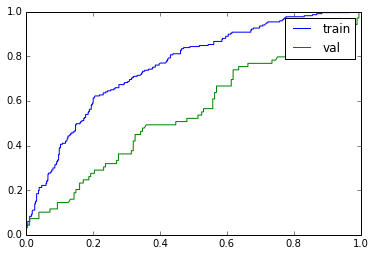

In [10]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve


for source_i, Xi,Yi in [
                            ["train",Xtr,Ytr],
                            ["val",Xval,Yval]
                                ]:
    
    # Предскажем вероятность сгорания
    Yi_pred_proba = model.predict_proba(Xi)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие
    Yi_pred_class = np.argsort(Yi_pred_proba) < 10000
    
    auc = roc_auc_score(Yi,Yi_pred_proba)
    acc = accuracy_score(Yi,Yi_pred_class)
    
    print '%s: \t AUC = %.5f \t Accuracy = %.5f'%(source_i, auc, acc)
    
    fpr,tpr,_ = roc_curve(Yi,Yi_pred_proba)
    
    plt.plot(fpr,tpr,label = source_i)
    
plt.legend()


Feature ranking:
1. dist (0.299162)
2. lat (0.246287)
3. lon (0.241503)
4. day_of_week=wed (0.116396)
5. f_class=business (0.020024)
6. f_class=econom (0.015453)
7. f_class=vip (0.014647)
8. s_class (0.006529)
9. s_class=business (0.000000)
10. s_class=econom (0.000000)
11. s_class=vip (0.000000)
12. t_class (0.000000)
13. t_class=business (0.000000)
14. t_class=econom (0.000000)
15. t_class=vip (0.000000)
16. time_of_day_rel (0.000000)
17. is_holiday (0.000000)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


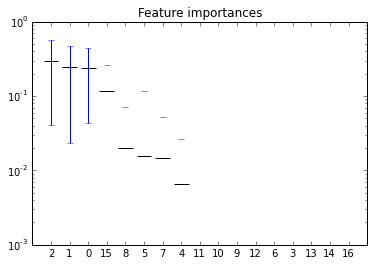

In [ ]:
from datanight import plot_forest_feature_importances
plot_forest_feature_importances(model,X.columns)

In [ ]:
from datanight import generate_submission
generate_submission(preprocess_data,model,"submission.csv")

# Советы по улучшению модели:

* Смотри глазами на данные - строй графики, исследуй аномалия 
 * это может принести новые идеи и отбросить нежизнеспособные намного раньше 
 * Туториал по библиотеке, в которой можно строить графики 
   * http://matplotlib.org/users/pyplot_tutorial.html
 * Ключевой вопрос самому себе - __"От чего ещё может зависеть, сгорит ли заказ?"__


* Попробуй более точно настроить модель или выбрать другую
 * Random Forest с текущими параметрами можно улучшить
   * Документация по нему - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
 * А можно использовать другие, более подходящие методы
   * Документация по методам - http://scikit-learn.org/stable/supervised_learning.html
 * Наконец, модели можно комбинировать
   * Например, усреднять с весами
   * В итоге качество может быть лучше, чем у каждой модели по отдельности
 * Важно не увлечься - зачастую качественные изменения решения намного лучше подкручивания параметров


* Подумай, какие ещё дополнительные данные можно провязать с выборкой? 
 * насколько реально применить их за отведённое время?


* __Главное__ - пытайся понять, дадут ли твои улучшения прирост на новых данных
 * Тестовая выборка находится по времени дальше, чем обучающая.
   * Например, нельзя использовать номер дня в году, потому что мы обучаемся на выборке __ДО__ начала контрольной
 * Это не значит, что нужно отправлять миллион решений на проверку и выбирать лучшее - это приведёт к переобучению
 

# MAPS

In [97]:
X.head(1)

,dist,lat,lon,day_of_week=fri,day_of_week=mon,day_of_week=sat,day_of_week=sun,day_of_week=thu,day_of_week=tue,day_of_week=wed,...,s_class,s_class=business,s_class=econom,s_class=vip,t_class,t_class=business,t_class=econom,t_class=vip,time_of_day_rel,is_holiday
0,17990.125431,55.75013,37.823242,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00625,True


In [96]:
import pygeoplot as gp
from IPython.display import Image

In [103]:
map_center = list(data[:10].ix[:, ['lat', 'lon']].mean())

In [121]:
points_map = gp.Map()
gp.placemarks_from_df(points_map, data.tail(10**3), lat_col='lat', lng_col='lon')
points_map.set_state(map_center, 5)

In [122]:
points_map.display()

In [126]:
littleX = X.sample(10**4)

map_center = list(littleX.ix[:, ['lat', 'lon']].median())
heatmap_points = [list(point) for i, point in littleX.ix[:, ['lat', 'lon']].iterrows()]

camera_density = gp.Map()
camera_density.add_heatmap(heatmap_points)
camera_density.set_state(map_center, 3)
camera_density.display(width=1000)

In [127]:
# moscow_center = [55.754216, 37.61343]
# voronej_center = [51.661535, 39.200287]
# novgorod_center = [56.326887, 44.005986]
# kazan_center = [55.798551, 49.106324]
# piter_center = [59.939095, 30.315868]
centers = [
    [55.754216, 37.61343],  #0
    [51.661535, 39.200287], #1
    [56.326887, 44.005986], #2
    [55.798551, 49.106324], #3
    [59.939095, 30.315868]  #4
]

In [128]:
from geopy.distance import vincenty

def city_id(coords):
    dist = []
    for c in centers:
        dist.append(vincenty(coords, c))
    dist = np.array(dist)
    return np.argmin(dist)

In [148]:
X.head(1)

,dist,lat,lon,day_of_week=fri,day_of_week=mon,day_of_week=sat,day_of_week=sun,day_of_week=thu,day_of_week=tue,day_of_week=wed,...,s_class,s_class=business,s_class=econom,s_class=vip,t_class,t_class=business,t_class=econom,t_class=vip,time_of_day_rel,is_holiday
0,17990.125431,55.75013,37.823242,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00625,True


In [ ]:
for x in X.head(10).values:
    print city_id([x[1], x[2]])
    
X['city_id'] = [city_id([x[1], x[2]]) for x in X.values]